# Lab 1 solutions

We'll give example code that can be used to solve most of the exercises.

First, let's create two functions that will make things simpler later on:
* `parse_lexicon()` - reads in the lexicon file into a dictionary structure
* `generate_symbol_tables()` - constructs WFST symbol tables for words, phones and HMM states

You don't need to look in detail at these two functions unless you are interested.

State symbols will be in the form `p_i` where `p` is a phone label, and `i` is the state number within the phone HMM.  For example `ax_1`. Phone and word symbols are just as contained in the lexicon.

In [1]:
import openfst_python as fst

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon_lab1.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

### Writing the basic HMM construction function

Now let's write a function to create a $n$-state HMM for any phone.  It uses a given start state, and returns the last state of the HMM.  (To keep the code clear, we're going to assume that the symbol table variables are all available globally).

In [2]:
def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, None, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, out_label, None, next_state))    
       
        current_state = next_state
        
    return current_state
    

### Solving the exercises

With the functions above, it's relatively straightforward to solve most of the exercises.  Here are some examples.

In [3]:
def generate_word_wfst(word):
    """ Generate a WFST for any word in the lexicon, composed of 3-state phone WFSTs.
        This will currently output word labels.  
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        word (str): the word to generate
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst()
    
    # create the start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        
        current_state = generate_phone_wfst(f, current_state, phone, 3)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f
  
# example
f = generate_word_wfst('peppers')
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

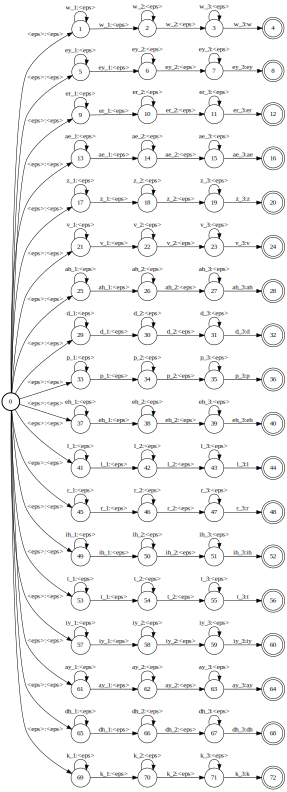

In [4]:
def generate_phone_recognition_wfst():
    """ generate a HMM to recognise any single phone in the lexicon (assumes 3-state HMMs per phone)
    
    Returns:
        the constructed WFST
    
    """
       
    # first, get a list of all the phones in the lexicon
    # there are lots of way to do this.  Here, we use the set() object

    # will contain all unique phones in the lexicon
    phone_set = set()
    
    for pronunciation in lex.values():
        phone_set = phone_set.union(pronunciation)

    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    for phone in phone_set:
        
        # we need to add an empty arc from the start state to where the actual phone HMM
        # will begin.  If you can't see why this is needed, try without it!
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
    
        end_state = generate_phone_wfst(f, current_state, phone, 3)
    
        f.set_final(end_state)
    
    return f
    
f = generate_phone_recognition_wfst()
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

### To try yourself...

1. Using all the above code, can you modify `generate_phone_recognition_wfst()`  above to generate an HMM that will recognise any sequence of phones in the lexicon?  (**hint**: try adding loops back to the start state).

2. Can you combine ideas from both `generate_phone_recognition_wfst()` and `generate_word_wfst()` to create an HMM that will recognise any sequence of words from "*peter piper picked a peck of pickled pepppers*"?